<h1><center>Intro to Data Science Industry Project</h1></center>
<h2><center>Columbia University Professor Rating System</h2></center>

# Table of contents
- [The Validation Set](#validation)
- [Using Logistic Regression For Sentiment Analysis](#modellingpranjal)
- [Using Random Forests For Sentiment Analysis](#modellingtreespranjal)
- [Unsupervised Analysis: PCA, NMF and Outlier Detection](#unsupervisedpranjal)

## Import block

In [1]:
# Basic Libraries 
import pandas as pd
import numpy as np

# Web Scraping Tools 
from bs4 import BeautifulSoup 
from urllib.request import urlopen
import re

# NLTK
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download() # only need to do this once

## Preprocessing for modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler


# Modelling 

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

## Unsupervised
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

## Plotting
import mglearn
import matplotlib.pyplot as plt

## Genism
import gensim
from gensim import corpora

# progress tracker 
from tqdm import tqdm

import warnings

/Users/pranjalbajaj/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# The Validation Set  <a name="validation"></a>

In [2]:
subset = pd.read_csv('dataframe_final.csv')[23391:] 

## Cleaning up

#### 1. Remove white spaces and symbols
- Remove  \r \r \r \n **from everywhere**

In [ ]:
#for i in range(len(subset)):
    #subset['review_text'][i] = subset['review_text'][i].strip()

#### 2. Re-label for modelling
- Neutral and Bad scores = 0 
- Positive Scores = 1
- Missing Values (at random) and Review Score = 0 were ignored

In [3]:
print("No. of Labels = 0: {:}".format(sum(subset['review_label'] == 0)))

No. of Labels = 0: 4


In [4]:
print("No. Missing of Labels: {:}".format(sum(subset['review_label'].isnull().values)))

No. Missing of Labels: 34


In [5]:
# Drop these Values 
subset = subset.dropna() # drop missing values 
subset.drop(subset[subset.review_label == 0].index, inplace=True) # drop labels = 0 

In [6]:
# Change one value that's 2 equal to 3
y = subset['review_label'].values
np.place(y, y == 3, [2])
# make positive scores = 1 and negative scores = 0 
np.place(y, y == 1, [0])
np.place(y, y == 2, [1])

# Classifying Reviews using the Natural Language Toolkit <a name="nltkpranjal"></a>

In [7]:
sid = SentimentIntensityAnalyzer()

In [8]:
reviews = subset['review_text'] # just the review column

In [9]:
all_pred_sentiments = []

for review in tqdm(reviews): # for each review, 
    pred_sentiment = sid.polarity_scores(review) # calculate the sentiment scores
    all_pred_sentiments.append(pred_sentiment) # and append them to a list

100%|██████████| 2021/2021 [00:04<00:00, 429.05it/s]


In [10]:
subset_copy = subset
subset_copy.agree_score = subset_copy.agree_score.apply(float)
subset_copy.disagree_score = subset_copy.disagree_score.apply(float)

In [11]:
all_pred_sentiments = pd.DataFrame(all_pred_sentiments)
all_pred_sentiments.reset_index(drop=True, inplace=True)
subset_copy.reset_index(drop=True, inplace=True)

In [12]:
subset_copy = pd.concat([subset_copy, pd.DataFrame(all_pred_sentiments)], axis=1) # add these new columns to our dataframe

#### Add weights for Agree/Disagree scores and append *Weighted Scores* to the DataFrame

$$ Weight = \frac{Agree}{Agree + Disagree}$$

In [13]:
weight = np.multiply(subset_copy['agree_score'], np.reciprocal(subset_copy['agree_score'] + subset_copy['disagree_score']))
weight = weight.fillna(1.0)
subset_copy['weight'] = weight
weighted_compound = np.multiply(np.transpose(subset_copy['weight']), subset_copy['compound'])
weighted_compound.name = 'weighted_compound'
subset_copy = pd.concat([subset_copy, weighted_compound], axis=1)

/Users/pranjalbajaj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  """Entry point for launching an IPython kernel.
/Users/pranjalbajaj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


#### Get Labels from scores

In [17]:
for i in tqdm(range(len(subset))):
    if subset_copy['weighted_compound'][i] > 0:
        subset_copy['weighted_compound'][i] = 1
    else:
        subset_copy['weighted_compound'][i] = 0 

  0%|          | 0/2021 [00:00<?, ?it/s]/Users/pranjalbajaj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
  0%|          | 3/2021 [00:00<02:45, 12.22it/s]/Users/pranjalbajaj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
100%|██████████| 2021/2021 [01:42<00:00, 19.80it/s]


#### Get prediction score with respect to ground truth

In [27]:
np.mean(weighted_compound != y)

0.9673428995546759

# Using Logistic Regression For Sentiment Analysis  <a name="modellingpranjal"></a>

Since, we do not have labels for our data, we use the sentiments form NLTK as ground truth and build a logistic regression model. We are assuming that NLTK provides us the ground truth, which is NOT true but we do this for exploratory purposes only and see which words/features contribute to the predicted sentiment and hence use that to improve our model

#### Check for imbalance in Dataset 

In [29]:
print("Positive Reviews: {:}".format(sum(y == 1)))
print("Negative Reviews: {:} ".format(sum(y == 0)))

Positive Reviews: 1437
Negative Reviews: 584 


Data is clearly imbalanced with roughly more 2 times more positive reviews than negative reviews/

#### Implement CountVectorizer and TfidfVectorizer to get bag of words

In [55]:
text = (subset['review_text'].values).astype('U')

# test-Train Split 
train, test, y_train, y_test = train_test_split(text, y, test_size = 0.2, random_state = 9598) #Splitting the data into Test and Train

vect_count = CountVectorizer(stop_words='english').fit(train) #, ngram_range = (1, 1), min_df = 0.005
bag_count = vect_count.transform(train)

# feature names
feature_names_count = vect_count.get_feature_names()

vect_tfidf = TfidfVectorizer(stop_words='english').fit(train) #, ngram_range = (1, 1), min_df = 0.005
bag_tfidf = vect_tfidf.transform(train)

# feature names
feature_names_tfidf = vect_tfidf.get_feature_names()


In [56]:
# Define Crossvalidation Strategy
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 9598)

#### Run Model: Countvectorizer

#### Initial Model

In [57]:
lr = LogisticRegression()
lr.fit(bag_count, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
scores = cross_val_score(LogisticRegression(class_weight='balanced'), bag_count, y_train, scoring='roc_auc', cv = cv ) 
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores))) 

Mean cross-validation accuracy: 0.88


#### Look at the top features i.e. words (for Initial Model)

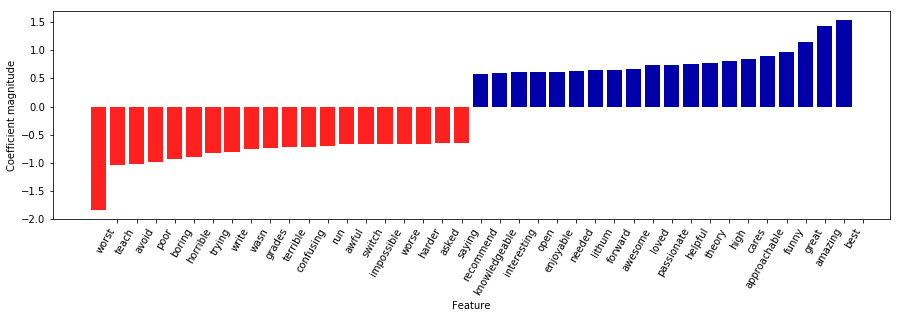

In [59]:
coefs = lr.coef_
mglearn.tools.visualize_coefficients(coefs, feature_names_count, n_top_features = 20)
plt.show()

#### Tuned Model

In [61]:
pipe_lr_count = make_pipeline(CountVectorizer(stop_words='english'), LogisticRegression(class_weight='balanced'))
param_grid = [{'logisticregression__C':np.logspace(-3, 0, 13)}, 
              {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
             {'countvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}] 
lr_grid_count = GridSearchCV(pipe_lr_count, param_grid, scoring='roc_auc', cv = cv)
lr_grid_count.fit(train, y_train)
print(lr_grid_count.best_score_)
print(lr_grid_count.best_params_)

0.8789324551185166
{'countvectorizer__ngram_range': (1, 2)}


#### Look at the top features i.e. words (Best Model)

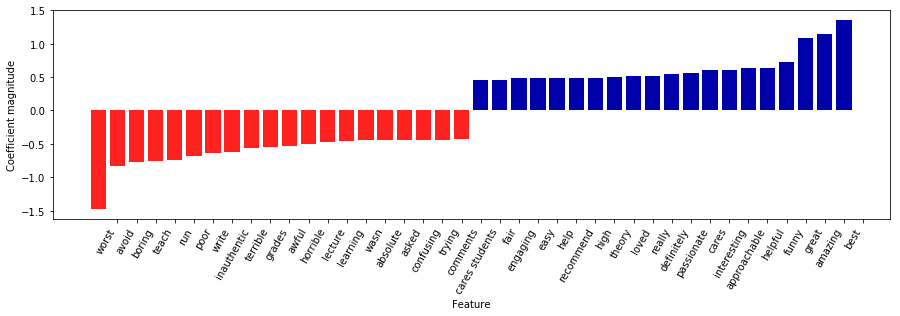

In [62]:
coef_lr_grid_count = lr_grid_count.best_estimator_.named_steps["logisticregression"].coef_
vect_count_lr_grid = lr_grid_count.best_estimator_.named_steps['countvectorizer']
feature_names_count_lr_grid = np.array(vect_count_lr_grid.get_feature_names())
mglearn.tools.visualize_coefficients(coef_lr_grid_count, feature_names_count_lr_grid , n_top_features = 20)
plt.show()                                                              

#### Run Model: TfidfVectorizer

#### Tuned Model

In [63]:
pipe_lr_tfidf = make_pipeline(TfidfVectorizer(stop_words='english'), LogisticRegression(class_weight='balanced'))
param_grid = [{'logisticregression__C':np.logspace(-3, 0, 13)}, 
              {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
             {'tfidfvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}] 
lr_grid_lr_tfidf = GridSearchCV(pipe_lr_tfidf, param_grid, scoring='roc_auc', cv = cv)

lr_grid_lr_tfidf.fit(train, y_train)
print(lr_grid_lr_tfidf.best_score_)
print(lr_grid_lr_tfidf.best_params_)

0.9122882437212658
{'logisticregression__C': 1.0}


#### Look at the top features i.e. words (Best Model)

In [ ]:
coef_lr_grid_tfidf = lr_grid_lr_tfidf.best_estimator_.named_steps["logisticregression"].coef_
vect_tfidf_lr_grid = _lr_tfidf.best_estimator_.named_steps['tfidfvectorizer']
feature_names_tfidf_lr_grid = np.array(vect_tfidf_lr_grid.get_feature_names())
mglearn.tools.visualize_coefficients(coef_lr_grid_tfidf, feature_names_tfidf_lr_grid, n_top_features = 20)
plt.show()                                                              

# Using Random Forests For Sentiment Analysis  <a name="modellingtreespranjal"></a>

#### Initial Model

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(bag_count, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [66]:
scores = cross_val_score(RandomForestClassifier(class_weight='balanced', random_state= 9598), bag_count, y_train, scoring='roc_auc', cv = cv ) 
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores))) 

Mean cross-validation accuracy: 0.81


#### Tuned Model: CountVectorizer

In [75]:
pipe_rf_count = make_pipeline(CountVectorizer(stop_words='english'), RandomForestClassifier(class_weight='balanced', random_state = 9598, max_depth = None,  max_leaf_nodes = None))
rf_grid = [{'randomforestclassifier__n_estimators': np.arange(50, 300, 50)},
           {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
           {'countvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}] 
rf_grid_count = GridSearchCV(pipe_rf_count, rf_grid, scoring='roc_auc', cv = cv)
rf_grid.fit(train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

AttributeError: 'list' object has no attribute 'fit'

#### Tuned Model: TfidfVectorizer

In [68]:
pipe_rf_tfidf = make_pipeline(TfidfVectorizer(stop_words='english'), RandomForestClassifier(class_weight='balanced', random_state = 9598, max_depth = None,  max_leaf_nodes = None))
rf_grid_tfidf = [{'randomforestclassifier__n_estimators': np.arange(50, 300, 50)},
           {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
           {'tfidfvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}] 
rf_grid = GridSearchCV(pipe_rf_tfidf, rf_grid_tfidf, scoring='roc_auc', cv = cv)
rf_grid.fit(train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.9020056916240738
{'randomforestclassifier__n_estimators': 250}


# Unsupervised Analysis: PCA, NMF and Outlier Detection <a name="unsupervisedpranjal"></a>

## PCA 
#### Get the top Principal Components using Truncated SVD

In [69]:
lsa = TruncatedSVD(n_components=100)
lsa.fit_transform(bag_count)
lsa.components_.shape

(100, 11508)

#### Selecting Optimal Principal Components

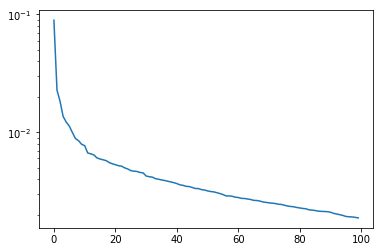

In [70]:
plt.semilogy(lsa.explained_variance_ratio_)
plt.show()

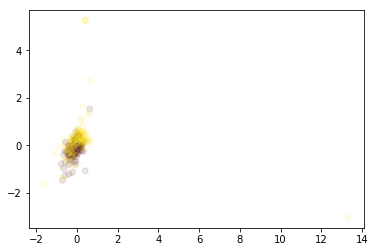

In [71]:
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(bag_count) # Scale the data
lsa_scaled = TruncatedSVD(n_components=100)

X_lsa_scaled = lsa_scaled.fit_transform(X_scaled)

plt.scatter(X_lsa_scaled[:, 1], X_lsa_scaled[:, 2], alpha=.1, c = y_train)
plt.show()

#### CountVectorizer with top 100 Principal compnent: Logistic Regression 

In [72]:
pipe = make_pipeline(CountVectorizer(stop_words='english'), MaxAbsScaler(), TruncatedSVD(n_components=100), LogisticRegression(class_weight='balanced'))
param_grid = [{'logisticregression__C':np.logspace(-3, 0, 13)}, 
              {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
             {'countvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}] 

lr_grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv = cv)
lr_grid.fit(train, y_train)
print(lr_grid.best_score_)
print(lr_grid.best_params_)

0.8710658617616699
{'logisticregression__C': 1.0}


#### TfidfVectorizer with top 100 Principal compnent: Logistic Regression 

In [74]:
pipe = make_pipeline(TfidfVectorizer(stop_words='english'), MaxAbsScaler(), TruncatedSVD(n_components=100), LogisticRegression(class_weight='balanced'))
param_grid = [{'logisticregression__C':np.logspace(-3, 0, 13)}, 
              {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
              {'tfidfvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}]  

lr_grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv = cv)
lr_grid.fit(train, y_train)
print(lr_grid.best_score_)
print(lr_grid.best_params_)

0.8777901596668017
{'logisticregression__C': 0.1778279410038923}


# Final Model: Test Set

In [76]:
lr_grid_lr_tfidf.score(test, y_test)

0.903104895104895

## Doc2Vec

In [31]:
from gensim.models import Doc2Vec

def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(line), [i])
            
train_corpus = list(read_corpus(train))
test_corpus = list(read_corpus(test, tokens_only=True))
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=55)

#### Check most similar words to a particular word 

In [53]:
model.wv.most_similar("science")

[('political', 0.6432818174362183),
 ('computer', 0.6205494999885559),
 ('psychology', 0.5977452993392944),
 ('philosophy', 0.5963426232337952),
 ('frontiers', 0.5616985559463501),
 ('psych', 0.5461146831512451),
 ('sociology', 0.5419831871986389),
 ('latin', 0.5402747392654419),
 ('econ', 0.5397531986236572),
 ('interested', 0.5383843779563904)]

In [33]:
vectors = [model.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]    
X_train = np.vstack(vectors)
X_train.shape

(1616, 50)

In [34]:
test_vectors = [model.infer_vector(test_corpus[doc_id])
                for doc_id in range(len(test_corpus))]   
X_test = np.vstack(test_vectors)

#### Test Score

In [54]:
lr = LogisticRegression(C = 100).fit(X_train, y_train)
lr.score(X_test, y_test)

0.7753086419753087

#### Get Vectors 

In [ ]:
def get_vector(tokens, model, num_features = 100):
    # Pre-initialising empty numpy array for speed
    vec = np.zeros(num_features, dtype="float32")
    nwords = 0
    
    index2word_set = set(model.wv.index2word)
    
    for t in  tokens:
        if t in index2word_set:
            nwords += 1
            vec = np.add(vec, model[t])

    return vec/nwords

In [ ]:
get_vector(train_words[0], model)
train_vecs = [get_vector(w, model) for w in train_words]
train_vecs

## Outlier Detection

#### Gaussian 

In [ ]:
ee = EllipticEnvelope(contamination=.005).fit(X_scaled) #10% outliers (but can we improve our guess?)
pred_ee = ee.predict(X_scaled) 
print(pred_ee)
print(np.mean(pred_ee == -1))

In [ ]:
print(roc_auc_score(y, pred_ee))

In [ ]:
oneclass = OneClassSVM(nu=.005).fit(X_scaled)
pred_oc = oneclass.predict(X_scaled)
print(pred_oc)
print(np.mean(pred_oc == -1))

In [ ]:
print(roc_auc_score(y, pred_oc))

#### Non-Probability based (and i.e. non-Gaussian)

In [ ]:
isoforest = IsolationForest(max_samples=256, contamination = .005, random_state=9598).fit(X_scaled)
# max_samples=’auto’, contamination=0.1, max_features=1.0, 
# bootstrap=False, n_jobs=1, verbose=0)
pred_if = isoforest.predict(X_scaled) 

In [ ]:
print(roc_auc_score(y, pred_if))

#### NMF Decomposition 

In [85]:
lr_lsa = LogisticRegression(C=100).fit(X_lsa_scaled[:, :10], y)

nmf_scale = NMF(n_components=100, verbose=0, tol=0.01) # verbose tells it to shut up and not update results
nmf_scale.fit(X_scaled)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=100, random_state=None, shuffle=False, solver='cd',
  tol=0.01, verbose=0)

In [65]:
coefs = nmf_scale.components_
feature_names = vect.get_feature_names()

#### LDA 

In [66]:
lda = LatentDirichletAllocation(n_components=10, learning_method="batch")
X_lda = lda.fit_transform(bag)

In [67]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch")
X_lda100 = lda100.fit_transform(bag)

In [ ]:
pd.DataFrame(lda100.components_)

#### LDA Produces Horrible Results: Need to fine tune... 

In [112]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, feature_names_tfidf, 10)

Topic %d:
daniel arvind roma dodd friedman 400 heather ml game postings
Topic %d:
dan daniela passages urdu insane pts tyerman miguel janet aftab
Topic %d:
stats levy korean rubenstein kim karen lead varzi mowsh experiment
Topic %d:
class professor final really workload course midterm students just time
Topic %d:
bayer ellsberg arbitrary af como postings christia blake cohen meaningful
Topic %d:
lilla nathan taylor quantum vogel krauss algos christina samuel carefully
Topic %d:
african crary dani film opaque garb dont clarity asian happens
Topic %d:
reports lab semesters answered struggle planning gen listenings drill arabic
Topic %d:
genius dont baker approximation insanely zarghamee ieee bro rieder gamber
Topic %d:
qi luke laoshi plays xavi neath sachin kat intaglio cloud
